<a href="https://colab.research.google.com/github/lyj18/vae/blob/master/code_size_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# load all libaries
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pyplot import plot, ion, show, savefig, cla, figure

print(tf.__version__)

1.14.0


In [2]:
# load all libaries
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pyplot import plot, ion, show, savefig, cla, figure
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import UpSampling2D
from matplotlib import pyplot
from keras import backend as K
K.set_image_dim_ordering('th')
from keras import Model
print(tf.__version__)
# import data - MNIST
mnist = tf.keras.datasets.mnist
(X_train, Y_train),(X_test, Y_test) = mnist.load_data()
(x_train, y_train),(x_test, y_test) = mnist.load_data()
#加上了一个正则 改了units
from keras import regularizers

1.14.0


Using TensorFlow backend.


11493376/11490434 [==============================] - 0s 0us/step


In [3]:
# import data - MNIST
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()
print("Training set is of size: {}".format(x_train.shape))
print("Test set is of size: {}".format(x_test.shape))
print("A MNIST image is of size: {}".format(x_train[0].shape))

Training set is of size: (60000, 28, 28)
Test set is of size: (10000, 28, 28)
A MNIST image is of size: (28, 28)


In [0]:
# Normalise the data
x_train, x_test = x_train / 255.0, x_test / 255.0
n_train = x_train.shape[0]
n_test = x_test.shape[0]

In [5]:
# define a dataset and an iterator
batch_size = 256
code_size_list = [2,4,8,16,32]
code_size = 16
input_image = tf.placeholder(tf.float32, [None, 28, 28, 1])
input_label = tf.placeholder(tf.int32, [None, 1])
seed = tf.placeholder(tf.int64, shape=())
dataset = tf.data.Dataset.from_tensor_slices((input_image, input_label))
dataset = dataset.shuffle(buffer_size=60000, seed=seed)
dataset = dataset.repeat(8000)
dataset = dataset.batch(batch_size, drop_remainder=True)
iterator = dataset.make_initializable_iterator()
batch_image, batch_label = iterator.get_next()

code_input = tf.placeholder(tf.float32, [None, code_size])
is_code_input = tf.placeholder(tf.bool)

W0816 06:41:52.192919 140366834366336 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/data/util/random_seed.py:58: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0816 06:41:52.202503 140366834366336 deprecation.py:323] From <ipython-input-5-966e4345c34b>:11: DatasetV1.make_initializable_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.


In [6]:
# build the auto-encoder model 
# encoder
"""
with tf.variable_scope('encoder'):
    input = tf.layers.flatten(input_image)
    encoded = tf.nn.leaky_relu(tf.layers.dense(input, units=256, activation=None), alpha=0.1)
    encoded = tf.layers.dense(encoded, units=256, activation=tf.nn.relu)
    encoded_code = tf.layers.dense(encoded, units=code_size, activation=None)
    # change for VAE
    encoded_code_std = tf.layers.dense(encoded, units=code_size, activation=tf.nn.relu)
    encoded_code_std = encoded_code_std + 1e-6
    mvn = tfp.distributions.MultivariateNormalDiag(
                loc=encoded_code,
                scale_diag=encoded_code_std)
    encoded_code_sample = mvn.sample()
print("finish encoder: \n{}".format(encoded_code))
print("\n")
    
# decoder
with tf.variable_scope('decoder'):
    embedding = tf.cond(is_code_input, lambda: code_input, lambda: encoded_code_sample)
    decoded = tf.layers.dense(embedding, units=256, activation=tf.nn.relu)
    decoded = tf.layers.dense(decoded, units=256, activation=tf.nn.relu)
    decoded_image = tf.layers.dense(decoded, units=28*28, activation=tf.nn.sigmoid)
    decoded_image = tf.reshape(decoded_image, [-1, 28, 28, 1])
print("finish decoder: \n{}".format(decoded_image))
print('\n')
encoder_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "encoder")
decoder_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "decoder")
trainable_vars_AE = encoder_vars + decoder_vars
"""

'\nwith tf.variable_scope(\'encoder\'):\n    input = tf.layers.flatten(input_image)\n    encoded = tf.nn.leaky_relu(tf.layers.dense(input, units=256, activation=None), alpha=0.1)\n    encoded = tf.layers.dense(encoded, units=256, activation=tf.nn.relu)\n    encoded_code = tf.layers.dense(encoded, units=code_size, activation=None)\n    # change for VAE\n    encoded_code_std = tf.layers.dense(encoded, units=code_size, activation=tf.nn.relu)\n    encoded_code_std = encoded_code_std + 1e-6\n    mvn = tfp.distributions.MultivariateNormalDiag(\n                loc=encoded_code,\n                scale_diag=encoded_code_std)\n    encoded_code_sample = mvn.sample()\nprint("finish encoder: \n{}".format(encoded_code))\nprint("\n")\n    \n# decoder\nwith tf.variable_scope(\'decoder\'):\n    embedding = tf.cond(is_code_input, lambda: code_input, lambda: encoded_code_sample)\n    decoded = tf.layers.dense(embedding, units=256, activation=tf.nn.relu)\n    decoded = tf.layers.dense(decoded, units=256,

In [12]:
def bias_variable(shape):
  initial=tf.constant(0.1,shape=shape)
  return tf.Variable(initial)
def weight_variable(shape):
  initial=tf.truncated_normal(shape,stddev=0.1)
  return tf.Variable(initial)
W_conv1=weight_variable([5,5,1,32])
W_conv2 = weight_variable([5, 5, 32, 64])
keep_prob = 0.8
with tf.variable_scope('encoder8', reuse=tf.AUTO_REUSE):
    input =tf.reshape(input_image, [-1,28,28,1]) 
    print(input)
    x = tf.nn.relu(tf.nn.conv2d(input,W_conv1,[1,1,1,1],padding='SAME')+bias_variable([32]))
    #keras x = Convolution2D(16, (3, 3), activation='relu', padding='same')(input)
    print(x)
    #16, 28, 1
    x = tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    #x = MaxPooling2D((2, 2), padding='same')(x)
    print(x)
    #16, 14, 1
    x = tf.nn.relu(tf.nn.conv2d(x,W_conv2,[1,1,1,1],padding='SAME')+bias_variable([64]))
    #x = Convolution2D(16, (3, 3), activation='relu', padding='same')(x)
    print(x)
    #16, 14, 1
    x = tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    print(x)
    #16, 7, 1
    #x =tf.reshape(x, [-1,16,7,1]) 
    #input = tf.layers.flatten(x)
    #input  = tf.reshape(x, [-1, 16*7*1])
    #16x7x1
    #print(input)
    #在第一个
    encoded = tf.nn.leaky_relu(tf.layers.dense(input, units=256,kernel_regularizer=regularizers.l2(0.001),activation=None), alpha=0.1)
    print(encoded)
    #encoded = tf.layers.dense(encoded, units=128, activation=tf.nn.relu)
    #print(encoded)
    #encoded_code = tf.layers.dense(encoded, units=code_size, activation=None)
    # change for VAE
   # print(encoded_code)
    encoded = tf.layers.dense(encoded,units=256,kernel_regularizer=regularizers.l2(0.001), activation=tf.nn.relu)
    print(encoded)
    encoded = tf.nn.dropout(encoded,keep_prob)
    encoded_code = tf.nn.softmax(tf.layers.dense(encoded, units=code_size, activation=None))
    # change for VAE
    print(encoded_code)
    encoded_code_std = tf.layers.dense(encoded, units=code_size, activation=tf.nn.relu)
    print(encoded_code_std)
    encoded_code_std = encoded_code_std + 1e-6
    print(encoded_code_std)
    mvn = tfp.distributions.MultivariateNormalDiag(
                loc=encoded_code,
                scale_diag=encoded_code_std)
    encoded_code_sample = mvn.sample()
print("finish encoder: \n{}".format(encoded_code))
print("\n")

# decoder
with tf.variable_scope('decoder8', reuse=tf.AUTO_REUSE):
    embedding = tf.cond(is_code_input, lambda: code_input, lambda: encoded_code_sample)
    print(embedding)
    decoded = tf.layers.dense(embedding, units=256, activation=tf.nn.relu)
    decoded = tf.layers.dense(decoded, units=256, activation=tf.nn.relu)
    decoded_image = tf.layers.dense(decoded, units=28*28, activation=tf.nn.sigmoid)
    decoded_image = tf.reshape(decoded_image, [-1, 28, 28, 1])
print("finish decoder: \n{}".format(decoded_image))
print('\n')
encoder_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "encoder8")
decoder_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "decoder8")
trainable_vars_AE = encoder_vars + decoder_vars
print(trainable_vars_AE)


W0816 07:30:29.022007 140366834366336 deprecation.py:506] From <ipython-input-12-f10b5046533d>:43: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Tensor("encoder8_5/Reshape:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("encoder8_5/Relu:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("encoder8_5/MaxPool:0", shape=(?, 14, 14, 32), dtype=float32)
Tensor("encoder8_5/Relu_1:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("encoder8_5/MaxPool_1:0", shape=(?, 7, 7, 64), dtype=float32)
Tensor("encoder8_5/LeakyRelu:0", shape=(?, 28, 28, 256), dtype=float32)
Tensor("encoder8_5/dense_1/Relu:0", shape=(?, 28, 28, 256), dtype=float32)
Tensor("encoder8_5/Softmax:0", shape=(?, 28, 28, 16), dtype=float32)
Tensor("encoder8_5/dense_3/Relu:0", shape=(?, 28, 28, 16), dtype=float32)
Tensor("encoder8_5/add_2:0", shape=(?, 28, 28, 16), dtype=float32)
finish encoder: 
Tensor("encoder8_5/Softmax:0", shape=(?, 28, 28, 16), dtype=float32)


Tensor("decoder8_3/cond/Merge:0", dtype=float32)


ValueError: ignored

In [0]:
# Define the loss function
reconstruction_loss = tf.reduce_sum(tf.square(input_image - decoded_image), [1, 2, 3])
reconstruction_loss = tf.reduce_mean(reconstruction_loss)
reconstruction_loss = tf.squeeze(reconstruction_loss)

# KL loss
KL_loss=0.5 * (tf.reduce_sum(tf.square(encoded_code), 1)
              + tf.reduce_sum(tf.square(encoded_code_std), 1)
              - tf.reduce_sum(tf.log(tf.square(encoded_code_std)), 1)
              - code_size)
KL_loss=tf.reduce_mean(KL_loss)
KL_loss = tf.squeeze(KL_loss)

# ELBO loss
elbo = reconstruction_loss + KL_loss
elbo = tf.squeeze(elbo)

# Learning through gradient descent
lr = 0.001
opt = tf.train.AdamOptimizer(learning_rate=lr,
                             beta1=0.9,
                             beta2=0.95)
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
gvs = opt.compute_gradients(elbo, var_list=trainable_vars_AE)
print('gvs: {}'.format(gvs))
def ClipIfNotNone(grad):
  if grad is None:
    return grad
  return tf.clip_by_value(grad, -1, 1)
capped_gvs = [(ClipIfNotNone(grad), var) for grad, var in gvs]
with tf.control_dependencies(update_ops):
    train_step = opt.apply_gradients(capped_gvs)
print("Reach the definition of loss")

saver = tf.train.Saver(max_to_keep=1, var_list=trainable_vars_AE)

gvs: [(None, <tf.Variable 'encoder8/conv2d_1/kernel:0' shape=(3, 3, 28, 16) dtype=float32_ref>), (None, <tf.Variable 'encoder8/conv2d_1/bias:0' shape=(16,) dtype=float32_ref>), (None, <tf.Variable 'encoder8/conv2d_2/kernel:0' shape=(3, 3, 16, 16) dtype=float32_ref>), (None, <tf.Variable 'encoder8/conv2d_2/bias:0' shape=(16,) dtype=float32_ref>), (<tf.Tensor 'gradients_1/encoder8/dense/MatMul_grad/tuple/control_dependency_1:0' shape=(784, 256) dtype=float32>, <tf.Variable 'encoder8/dense/kernel:0' shape=(784, 256) dtype=float32_ref>), (<tf.Tensor 'gradients_1/encoder8/dense/BiasAdd_grad/tuple/control_dependency_1:0' shape=(256,) dtype=float32>, <tf.Variable 'encoder8/dense/bias:0' shape=(256,) dtype=float32_ref>), (<tf.Tensor 'gradients_1/encoder8/dense_1/MatMul_grad/tuple/control_dependency_1:0' shape=(256, 256) dtype=float32>, <tf.Variable 'encoder8/dense_1/kernel:0' shape=(256, 256) dtype=float32_ref>), (<tf.Tensor 'gradients_1/encoder8/dense_1/BiasAdd_grad/tuple/control_dependency_1

In [0]:
def plot_reconstructed_signal(x_test, y_test, reconstructed_image):
    # plot the reconstructed image for a shape
    fig, axs = plt.subplots(2, 10, figsize=(18, 4), edgecolor='k')
    fig.subplots_adjust(hspace=.4, wspace=.4)
    axs = axs.ravel()
    for j in range(2):
        if j == 0:
            image_to_plot = x_test
        else:
            image_to_plot = np.squeeze(reconstructed_image)
        for i in range(10):
            axs[i+j*10].imshow(image_to_plot[i], cmap='gray')
            axs[i+j*10].grid(False)
            if j == 0: 
                axs[i+j*10].set_title("original {}".format(y_test[i]))
            else:
                axs[i+j*10].set_title("reconstructed {}".format(y_test[i]))
            axs[i+j*10].set_xticks([])
            axs[i+j*10].set_yticks([])
            # plt.tight_layout()
#         savefig(save_path + 'test_reconstructed_{}.pdf'.format(cur_epoch))
#         fig.clf()
#         plt.close()
    plt.show()

In [0]:
# start training
sess = tf.Session()
# initialise all variables
init = tf.group(tf.global_variables_initializer(),
                tf.local_variables_initializer())
sess.run(init)

At epoch 0, ELBO: training: 47.2533, test: 41.5473; 
reconstruction error: training: 44.7039, test: 38.7229; 
KL loss: training: 2.5494, test: 2.8245.


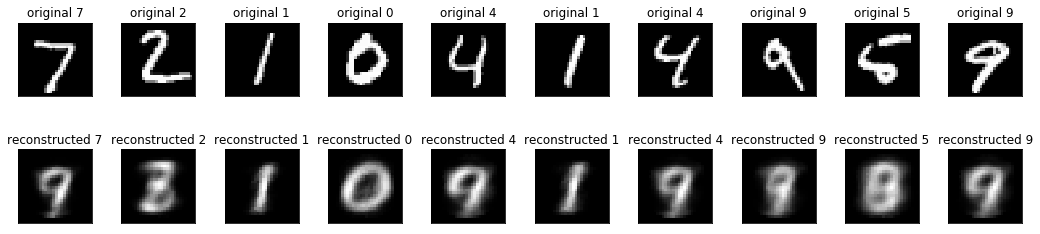

Model saved in path: ./VAE-model.ckpt
At epoch 1, ELBO: training: 42.3229, test: 40.0643; 
reconstruction error: training: 39.0957, test: 36.7006; 
KL loss: training: 3.2272, test: 3.3637.


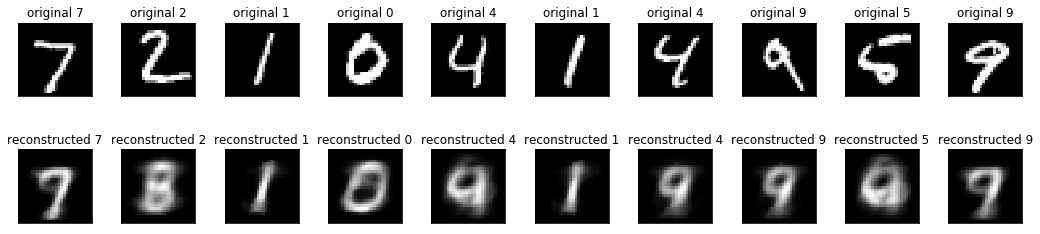

Model saved in path: ./VAE-model.ckpt
At epoch 2, ELBO: training: 41.7729, test: 39.1938; 
reconstruction error: training: 38.3331, test: 35.7120; 
KL loss: training: 3.4398, test: 3.4818.


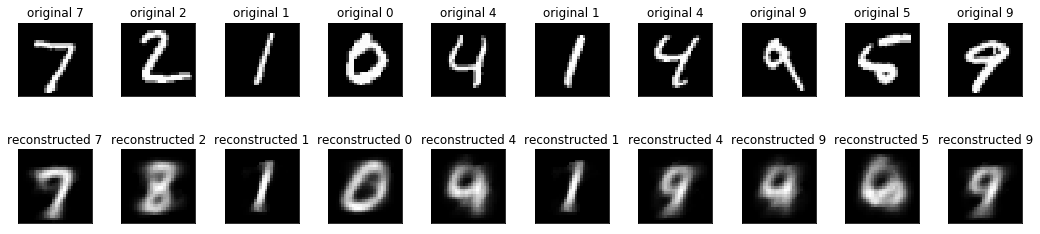

Model saved in path: ./VAE-model.ckpt
At epoch 3, ELBO: training: 39.7639, test: 38.9653; 
reconstruction error: training: 35.9869, test: 35.3736; 
KL loss: training: 3.7770, test: 3.5917.


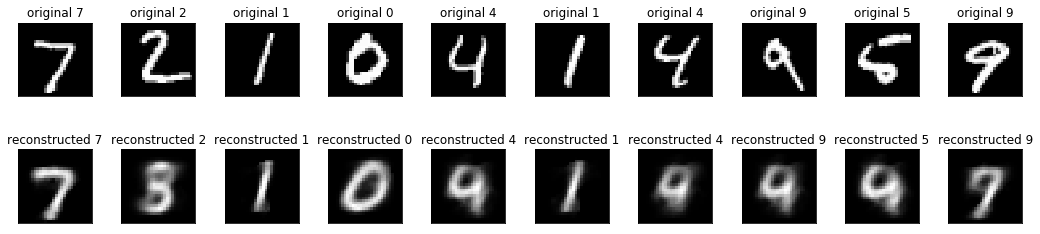

Model saved in path: ./VAE-model.ckpt
At epoch 4, ELBO: training: 39.3093, test: 39.0330; 
reconstruction error: training: 35.3139, test: 35.2734; 
KL loss: training: 3.9954, test: 3.7596.


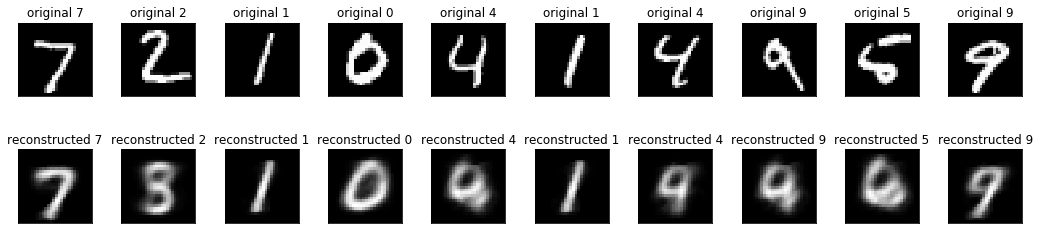

Model saved in path: ./VAE-model.ckpt
At epoch 5, ELBO: training: 38.8560, test: 37.9691; 
reconstruction error: training: 34.5706, test: 33.8900; 
KL loss: training: 4.2854, test: 4.0791.


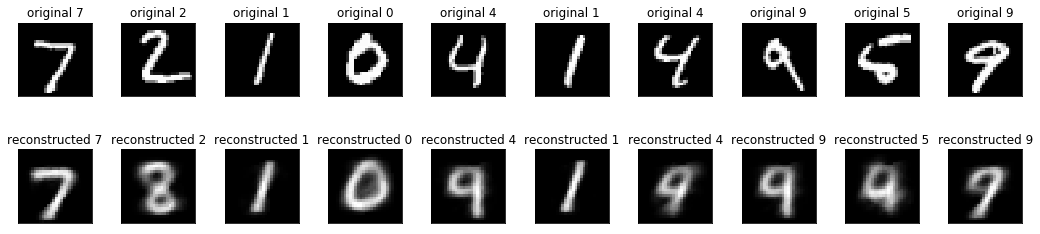

Model saved in path: ./VAE-model.ckpt
At epoch 6, ELBO: training: 38.7760, test: 36.4873; 
reconstruction error: training: 34.6212, test: 32.4072; 
KL loss: training: 4.1548, test: 4.0801.


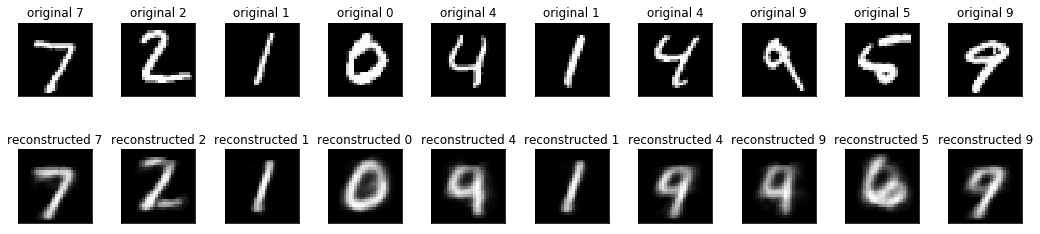

Model saved in path: ./VAE-model.ckpt
At epoch 7, ELBO: training: 39.6527, test: 37.6444; 
reconstruction error: training: 35.3254, test: 33.4120; 
KL loss: training: 4.3273, test: 4.2325.


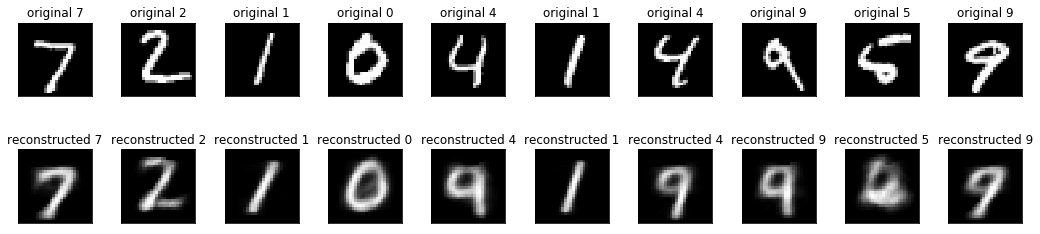

Model saved in path: ./VAE-model.ckpt
At epoch 8, ELBO: training: 37.1643, test: 35.6477; 
reconstruction error: training: 32.7142, test: 31.0460; 
KL loss: training: 4.4501, test: 4.6018.


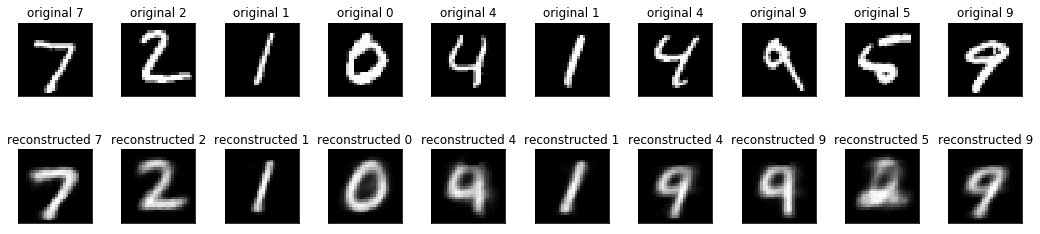

Model saved in path: ./VAE-model.ckpt
At epoch 9, ELBO: training: 37.4161, test: 34.5873; 
reconstruction error: training: 32.7758, test: 29.8585; 
KL loss: training: 4.6403, test: 4.7288.


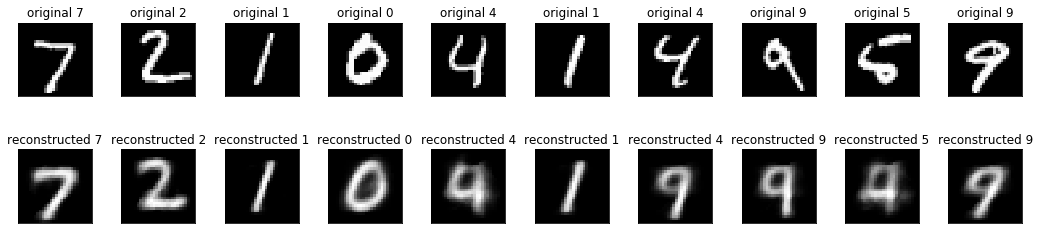

Model saved in path: ./VAE-model.ckpt


In [0]:
n_epoch = 10
train_elbo = []
train_reconstruction = []
train_KL = []
val_elbo = []
val_reconstruction = []
val_KL = []
n_train_iter = n_train // batch_size
for cur_epoch in range(n_epoch):
    sess.run(iterator.initializer,
             feed_dict={input_image: np.expand_dims(x_train, -1),
                        input_label: np.expand_dims(y_train, -1),
                        seed: cur_epoch})
    # training stage
    for i in range(n_train_iter):
        training_image, training_label = sess.run([batch_image, batch_label])
        feed_dict = {input_image: training_image,
                     input_label: training_label,
                     is_code_input: False,
                     code_input: np.zeros((batch_size, code_size))}
        elbo_train, train_res, train_kl, _ = sess.run([elbo, reconstruction_loss, KL_loss, train_step], feed_dict=feed_dict)
        train_elbo.append(elbo_train)
        train_reconstruction.append(train_res)
        train_KL.append(train_kl)
    
    # validation stage
    feed_dict = {input_image: np.expand_dims(x_test[:10], -1),
                 input_label: np.expand_dims(y_test[:10], -1),
                 is_code_input: False,
                 code_input: np.zeros((10, code_size))}
    elbo_val, res_val, kl_val, reconstructed_image = sess.run([elbo, reconstruction_loss, KL_loss, decoded_image], feed_dict=feed_dict)
    val_elbo.append(elbo_val)
    val_reconstruction.append(res_val)
    val_KL.append(kl_val)
    print("At epoch {}, ELBO: training: {:.4f}, test: {:.4f}; \nreconstruction error: training: {:.4f}, test: {:.4f}; \nKL loss: training: {:.4f}, test: {:.4f}.".format(cur_epoch, elbo_train, elbo_val, train_res, res_val, train_kl, kl_val))
    plot_reconstructed_signal(x_test, y_test, reconstructed_image)
    
    # save the trained model
    saved_model_name = "./VAE-model.ckpt"
    save_path = saver.save(sess, saved_model_name)
    print("Model saved in path: {}".format(save_path))

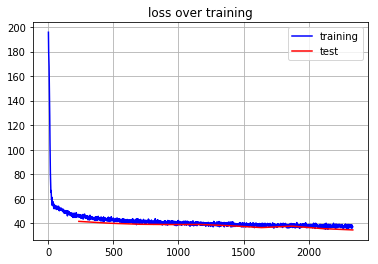

In [0]:
# plot training and test error
plt.plot(train_elbo, 'b-')
plt.plot(n_train_iter * np.arange(1, n_epoch+1, 1), val_elbo, 'r-')
plt.grid(True)
plt.title('loss over training')
plt.legend(('training', 'test'))
plt.show()

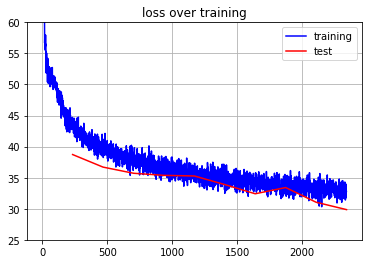

In [0]:
# plot training and test error
plt.plot(train_reconstruction, 'b-')
plt.plot(n_train_iter * np.arange(1, n_epoch+1, 1), val_reconstruction, 'r-')
plt.grid(True)
plt.ylim([25,60])
plt.title('loss over training')
plt.legend(('training', 'test'))
plt.show()

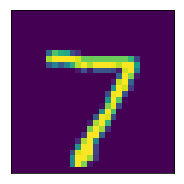

In [0]:
figure(figsize=(3,3))
plt.imshow(x_test[0])
plt.xticks([])
plt.yticks([])
plt.show()

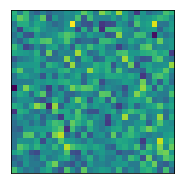

[ 0.85766298 -0.4440129   1.02137295 -0.74875975 -1.28248086 -0.41394247
 -1.15697607 -0.61495823 -0.57690878 -0.04621397]


In [0]:
noise = np.random.normal(loc=0., scale=1., size=28*28)
noise = np.reshape(noise, (28,28))
figure(figsize=(3,3))
plt.imshow(noise)
plt.xticks([])
plt.yticks([])
plt.show()
print(noise[0,:10])

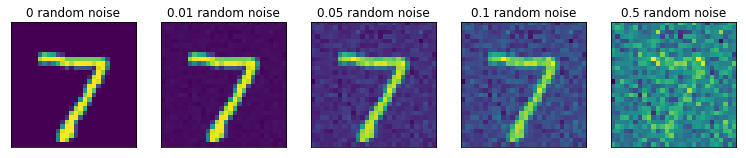

In [0]:
fig, axs = plt.subplots(1, 5, figsize=(13, 3), edgecolor='k')
axs = axs.ravel()
noise_amp = (0, 0.01, 0.05, 0.1, 0.5)
for i in range(5):
  axs[i].imshow(noise_amp[i]*noise+x_test[0])
  axs[i].set_xticks([])
  axs[i].set_yticks([])
  axs[i].set_title("{} random noise".format(noise_amp[i]))
plt.show()

In [0]:
# compute the embedding of the perturbed x_test[0] image
x_perturbed_0 = np.zeros((5,28,28))
for i in range(5):
  x_perturbed_0[i] = x_test[0] + noise_amp[i]*noise
  
feed_dict = {input_image: np.expand_dims(x_perturbed_0, -1),
             input_label: np.expand_dims(y_test[:5], -1),
             is_code_input: False,
             code_input: np.zeros((5, code_size))}
encoded_code_perturbed = sess.run(encoded_code, feed_dict = feed_dict)
print(encoded_code_perturbed.shape)
print(encoded_code_perturbed)

(5, 2)
[[-1.1782414  1.5177305]
 [-1.1830629  1.5096401]
 [-1.2020104  1.4773161]
 [-1.2308017  1.4363002]
 [-2.508182   1.2085555]]


[[-0.00482154 -0.00809038]
 [-0.02376902 -0.04041433]
 [-0.05256033 -0.08143032]
 [-1.3299407  -0.309175  ]]


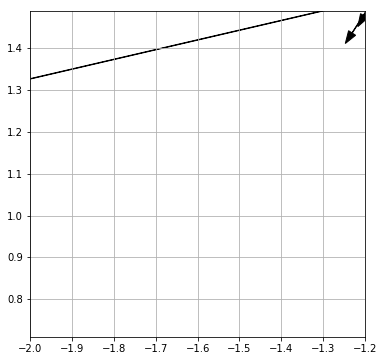

In [0]:
# visualise the change in the code space
diff_code = encoded_code_perturbed[1:] - encoded_code_perturbed[0]
print(diff_code)

figure(figsize=(6,6))
# P.arrow( x, y, dx, dy, **kwargs )
for i in range(4):
  plt.arrow( encoded_code_perturbed[0,0], encoded_code_perturbed[0,1], diff_code[i,0], diff_code[i,1], fc="k", ec="k", head_width=0.02, head_length=0.03 )
plt.axis('equal')
plt.axis((-2.,-1.2,0.7,1.5))
plt.grid(True)
plt.show()